In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.fig_utils import full_dist_to_print, dataset_to_print, dist_to_color, dist_to_print, full_dist_to_color
from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, filter_dgms
import os
import numpy as np
import glasbey

In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# UMAP with higher embedding dimension

In [4]:
datasets = ["toy_circle", "inter_circles", "eyeglasses", "torus", "toy_sphere"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different sigmas for eyeglasses
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

In [6]:
distances = {
    "euclidean": [{}],
    "umap_embd": [
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean"},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean"},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean"},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 3},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 3},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 3},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 5},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 5},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 5},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 10},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 10},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean", "vis_dim": 10},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
}


In [7]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 umap_embd_k_15_n_epochs_750_min_dist_0.1_metric_euclidean n_outliers=0
Done with toy_circle 50 umap_embd_k_100_n_epochs_750_min_dist_0.1_metric_euclidean n_outliers=0
Done with toy_circle 50 umap_embd_k_999_n_epochs_750_min_dist_0.1_metric_euclidean n_outliers=0
Done with toy_circle 50 umap_embd_k_15_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_3 n_outliers=0
Done with toy_circle 50 umap_embd_k_100_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_3 n_outliers=0
Done with toy_circle 50 umap_embd_k_999_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_3 n_outliers=0
Done with toy_circle 50 umap_embd_k_15_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_5 n_outliers=0
Done with toy_circle 50 umap_embd_k_100_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_5 n_outliers=0
Done with toy_circle 50 umap_embd_k_999_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_5 n_outliers=0
Done with toy_circle 50 umap_emb

In [8]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [9]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "eyeglasses": 1,
        "toy_sphere": 1,  # so that the curves are low
        "torus": 2,
        "inter_circles": 2,
    },
    2: {
        "toy_sphere": 1,
        "torus": 1 
    }
}

outlier_scores_1d = {dataset: compute_outlier_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1)
                     for dataset in cycles_per_dataset[1]}
outlier_scores_2d = {dataset: compute_outlier_scores(all_res[dataset],
                                                     n_features=cycles_per_dataset[2][dataset],
                                                     dim=2)
                     for dataset in cycles_per_dataset[2]}

outlier_scores = {
    1: outlier_scores_1d,
    2: outlier_scores_2d
}

In [10]:
# compute area under the curves
aucs = {}

for feature_dim in outlier_scores:
    auc_by_feature_dim = {}
    for dataset in outlier_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in outlier_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in outlier_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [11]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [13]:
# print best hyperparameter settings 
for feature_dim in best_method_per_dataset:
    print("~"*40)
    print(f"Topological dimension: {feature_dim}")
    for dataset in best_method_per_dataset[feature_dim]:
        for dist in best_method_per_dataset[feature_dim][dataset]:
            print(dataset_to_print[dataset], full_dist_to_print[best_method_per_dataset[feature_dim][dataset][dist]].replace("\n", " "))
        print("\n")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 1
Circle Euclidean
Circle UMAP $k=15, \tilde{d}=10$
Circle Effective resistance $k=100$


Eyeglasses Euclidean
Eyeglasses UMAP $k=15, \tilde{d}=10$
Eyeglasses Effective resistance $k=15$


Sphere Euclidean
Sphere UMAP $k=15$
Sphere Effective resistance $k=100$


Torus Euclidean
Torus UMAP $k=15$
Torus Effective resistance $k=100$


Linked circles Euclidean
Linked circles UMAP $k=15, \tilde{d}=5$
Linked circles Effective resistance $k=15$


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 2
Sphere Euclidean
Sphere UMAP $k=100, \tilde{d}=10$
Sphere Effective resistance $k=100$


Torus Euclidean
Torus UMAP $k=999, \tilde{d}=5$
Torus Effective resistance $k=100$


In [14]:
# extend colorbar for UMAP
shift = len(distances["umap_embd"])
colors = glasbey.create_block_palette([3, 3, 3, 3, 3])
for i, full_dist in enumerate(all_res["toy_circle"]["umap_embd"]):
    if "vis_dim" in full_dist:
        i = i+3 if i>=3 else i
        full_dist_to_color[full_dist] = colors[i]

['#995e00', '#bfa100', '#d7e783', '#520087', '#b400d6', '#ff76df', '#5b7a00', '#08c312', '#00ff9f', '#005a92', '#008df6', '#a9bfff', '#60001e', '#c61620', '#ff7b33']


In [16]:
# select all UMAP results for printing, but only the best eff res for clarity
print_res = {}
for feature_dim in outlier_scores:
    res_by_feature_dim = {}
    for dataset in cycles_per_dataset[feature_dim]:
        res_by_data = {}
        for distance in all_res[dataset]:
            if distance == "umap_embd":
                res_by_dist = list(all_res[dataset][distance].keys())
            else:
                res_by_dist = [best_method_per_dataset[feature_dim][dataset][distance]]
            res_by_data[distance] = res_by_dist
        res_by_feature_dim[dataset] = res_by_data
    print_res[feature_dim] = res_by_feature_dim

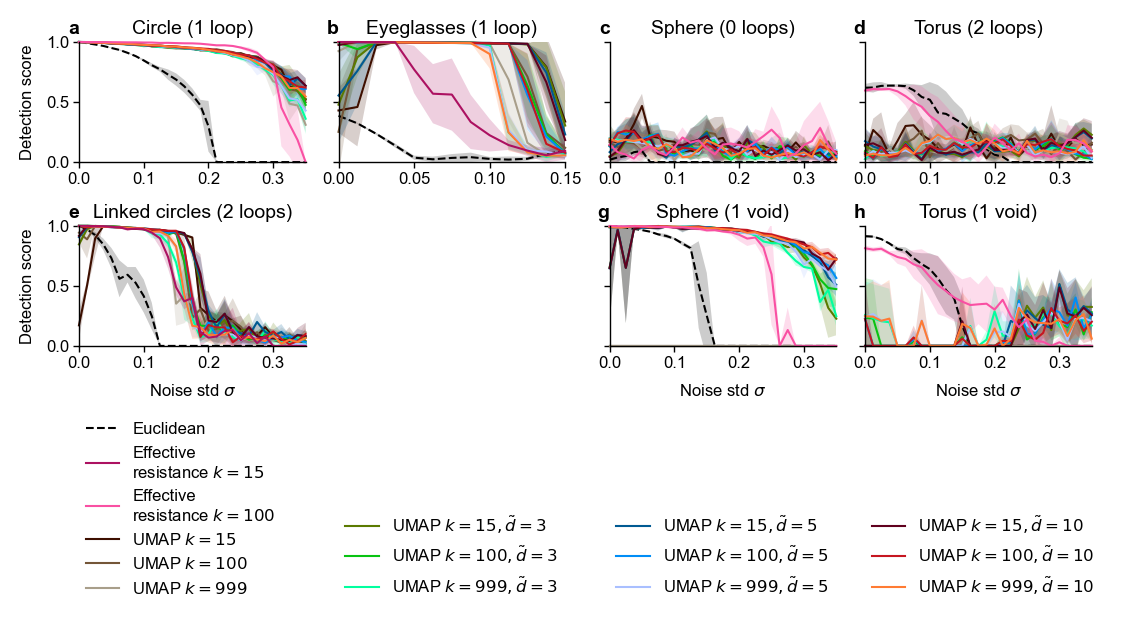

In [17]:
# plot figure
npanels = len(cycles_per_dataset[1]) + len(cycles_per_dataset[2]) +1
nrows = 3
ncols =  int(np.ceil(npanels /2))


fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5.5, 3.))

y_label="Detection score"

letters = "abcdefgh"

shift = 0

for i in range(npanels):
    feature_dim = 1 if i < len(cycles_per_dataset[1]) else 2
    if i == 5: 
        shift = 1
        continue
    j = (i-shift) % len(cycles_per_dataset[1])
    dataset = list(cycles_per_dataset[feature_dim].keys())[j]
    
    r, c  = int(i / ncols), i % ncols

    
    for dist in print_res[feature_dim][dataset]:
        for full_dist in print_res[feature_dim][dataset][dist]:
            mean = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1)
            std = outlier_scores[feature_dim][dataset][dist][full_dist].std(1)
            
            if dist != "euclidean":
                ax[r, c].plot(sigmas_per_dataset[dataset], 
                           mean,
                            label=full_dist_to_print[full_dist],
                            color=full_dist_to_color[full_dist],
                           clip_on=False)
                ax[r, c].fill_between(
                    sigmas_per_dataset[dataset],
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=full_dist_to_color[full_dist],
                    edgecolor=None,
                )
                
            else:
                ax[r, c].plot(sigmas_per_dataset[dataset], 
                              mean,
                              label=full_dist_to_print[full_dist],
                              color=full_dist_to_color[full_dist],
                              clip_on=False,
                              linestyle="dashed")
                ax[r,c ].fill_between(
                    sigmas_per_dataset[dataset],
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=full_dist_to_color[full_dist],
                    edgecolor=None,
                )       
        
    ax[r, c].set_ylim(0, 1)
    ax[r, c].set_xlim(0, sigmas_per_dataset[dataset].max())
    ax[r, c].set_xlabel("Noise std $\sigma$")
    if c==0:
        ax[r, c].set_ylabel(y_label)
        
    if c > 0:
        ax[r, c].set_yticklabels([])
    if r == 0:
        ax[r, c].set_xlabel("")
        
        
    if i == 0 or i==1:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 loop)")
    elif i == 2:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (0 loops)")
    elif i==3 or i==4:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (2 loops)")
    elif i==6 or i==7:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 void)")  
    
    
    ax[r, c].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)


handles, labels = ax[1, 2].get_legend_handles_labels()
handles2, labels2 = ax[0, 1].get_legend_handles_labels()

handles.insert(1, handles2[-1])
handles.insert(2, handles[-1])
handles.pop(-1)

labels.insert(1, labels2[-1])
labels.insert(2, labels[-1])
labels.pop(-1)

order = [0, -2, -1, ]

for i in range(4):
    if i == 0:
        my_slice = slice(0, 6, 1)
    else:
        my_slice = slice(3+3*i, 6+3*i, 1)
        
    ax[2, i].legend(loc=(0.0, 0.0),
                handles=handles[my_slice],
                frameon=False,
      )
    ax[2, i].axis("off")
ax[1, 1].axis("off")
fig.savefig(os.path.join(fig_path, "fig_datasets_highD_umap.pdf"), dpi=200)

## inspect sample UMAP results

In [21]:
import pickle
from persim import plot_diagrams
from utils.fig_utils import plot_dgm_loops
from sklearn.decomposition import PCA
from vis_utils.plot import plot_scatter
from utils.fig_utils import plot_edges_on_scatter
from utils.pd_utils import get_persistent_feature_id

In [ ]:
# sample umap plot for 
sigma = 0.0
k = 15
seed = 2
vis_dim = 3
size = 6

linestyles=["solid", "dotted"]
letters = "abcdefgh"
highlight_colors = [plt.get_cmap("tab10")(i) for i in [2, 5]]


embd_file_name = f"umap_n_1000_d_50_ortho_gauss_sigma_{sigma}_k_{k}_metric_euclidean_epochs_750_seed_{seed}_min_dist_0.1_init_pca_vis_dim_{vis_dim}.pkl"

datasets = ["eyeglasses", "toy_sphere", "torus"]

mosaic = np.array([[f"{i}{j}" for i in range(3)] for j in range(2)])

mosaic_kw = {idx_str: {} if idx_str[1] == "1" else {"projection": "3d"} for idx_str in mosaic.flatten()}
fig, ax = plt.subplot_mosaic(mosaic, per_subplot_kw=mosaic_kw, figsize=(5.5, 3), height_ratios=[1, 0.3])

ax = np.array([[ax[idx_str] for idx_str in row] for row in mosaic])

for i, dataset in enumerate(datasets):
    with open(os.path.join(root_path, dataset, embd_file_name), "rb") as f:
        umapper = pickle.load(f)


    embd_for_plot = PCA(3).fit_transform(umapper.embedding_)

    res = all_res[dataset]["umap_embd"][f"umap_embd_k_{k}_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_{vis_dim}"][sigma][seed]
    #plot_dgm_loops(res, embd = embd_for_plot, y="k", plot_only=[1], n_loops=3, ax=ax[i])
    
    plot_scatter(ax=ax[0, i],
                 x=embd_for_plot,
                 y="k",
                 scalebar=False,
                 alpha=0.2,
                 s=size+4)
    ax[0, i].axis("on")
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])
    ax[0, i].set_zticklabels([])
    
    


    plot_diagrams(res["dgms"],
                  plot_only=[1], 
                  ax=ax[1, i], 
                  color="k", 
                  size=size,
                  colormap=style_file, # necessary bc plot_diagrams uses the colormap as mpl style
                  )
    idx = [get_persistent_feature_id(res, dim=1, m=m+1) for m in range(2)] 

    for j, id in enumerate(idx):
        ax[1, i].scatter(*res["dgms"][1][id].T,
                         color=highlight_colors[j],
                         s=size+2
                         )
        plot_edges_on_scatter(ax=ax[0, i],
                             edge_idx = res["cycles"][1][id],
                             x=embd_for_plot,
                             color=highlight_colors[j],
                             linewidth=0.75,
                             linestyle=linestyles[j],
                             alpha=1,
                             )
        ax[1, i].legend(handletextpad=.1,
                        loc="lower right")
    if i < 3:
        ax[0, i].view_init(100, 45-180)
    else:
        ax[0, i].view_init(100-180, 45)
    print(len(res["dgms"][2]))
    
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])
    
    
    ax[0, i].set_title(
        letters[i]+"\n",
        loc="left",
        ha="right",
        fontweight="bold",
    )    
    
    ax[0, i].set_title(dataset_to_print[dataset]+"\n")
    
    #ax[i,0].set_ylabel(f"$\sigma={sigma}$\nDeath")
fig.savefig(os.path.join(fig_path, f"fig_high_umap_examples_sigma_{sigma}_k_{k}_vis_dim_{vis_dim}.pdf"), dpi=200)

## check noise dependence for the 3D datasets

In [28]:
sigmas_sphere = [0.0, 0.2, 0.35]
sigmas_torus = [0.0, 0.2, 0.35]
k = 100
seed = 0

In [ ]:
%matplotlib inline
mosaic = np.array([[f"{i}{j}" for i in range(4)] for j in range(3)])
mosaic_kw = {idx_str: {} if idx_str[0] == "0" else {"projection": "3d"} for idx_str in mosaic.flatten()}
fig, ax = plt.subplot_mosaic(mosaic, per_subplot_kw=mosaic_kw, figsize=(7.5, 5.5))

ax = np.array([[ax[idx_str] for idx_str in row] for row in mosaic])

for i, sigma in enumerate(sigmas_sphere):
    embd_file_name = f"umap_n_1000_d_50_ortho_gauss_sigma_{sigma}_k_{k}_metric_euclidean_epochs_750_seed_{seed}_min_dist_0.1_init_pca_vis_dim_3.pkl"
    with open(os.path.join(root_path, "toy_sphere", embd_file_name), "rb") as f:
        umapper = pickle.load(f)
    embd_for_plot = PCA(3).fit_transform(umapper.embedding_)
    res = all_res["toy_sphere"]["umap_embd"][f"umap_embd_k_{k}_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_3"][sigma][seed]
    plot_dgm_loops(res, embd = embd_for_plot, y="k", plot_only=[1], n_loops=3, ax=ax[i])
    
    if len(res["dgms"][2]) >0 :
        plot_diagrams(res["dgms"], plot_only=[2], ax=ax[i, 0], color=None, size=5)
    
    ax[i,0].set_ylabel(f"$\sigma={sigma}$\nDeath")
fig.savefig(os.path.join(fig_path, "fig_toy_sphere_umap_no_filtering.png"), dpi=200)

In [ ]:
%matplotlib inline
mosaic = np.array([[f"{i}{j}" for i in range(4)] for j in range(3)])
mosaic_kw = {idx_str: {} if idx_str[0] == "0" else {"projection": "3d"} for idx_str in mosaic.flatten()}
fig, ax = plt.subplot_mosaic(mosaic, per_subplot_kw=mosaic_kw, figsize=(7.5, 5.5))

ax = np.array([[ax[idx_str] for idx_str in row] for row in mosaic])

for i, sigma in enumerate(sigmas_sphere):
    embd_file_name = f"umap_n_1000_d_50_ortho_gauss_sigma_{sigma}_k_{k}_metric_euclidean_epochs_750_seed_{seed}_min_dist_0.1_init_pca_vis_dim_3.pkl"
    with open(os.path.join(root_path, "torus", embd_file_name), "rb") as f:
        umapper = pickle.load(f)
    embd_for_plot = PCA(3).fit_transform(umapper.embedding_)
    res = all_res["torus"]["umap_embd"][f"umap_embd_k_{k}_n_epochs_750_min_dist_0.1_metric_euclidean_vis_dim_3"][sigma][seed]
    plot_dgm_loops(res, embd = embd_for_plot, y="k", plot_only=[1], n_loops=3, ax=ax[i])
    
    
    if len(res["dgms"][2]) >0 :
        plot_diagrams(res["dgms"], plot_only=[2], ax=ax[i, 0], color=None, size=5)
    
    ax[i,0].set_ylabel(f"$\sigma={sigma}$\nDeath")
fig.savefig(os.path.join(fig_path, "fig_torus_umap_no_filtering.png"), dpi=200)